## Dataset
https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098

Land (unpaved area): #8429F6

Road: #6EC1E4

Vegetation: #FEDD3A

Water: #E2A929

Unlabeled: #9B9B9B

## Prediction on cropped section of larger tile

In [1]:
import glob
import cv2
import numpy as np
path1=glob.glob('./saved_data/images/*.*')
path2=glob.glob('./saved_data/masks/*.*')

images=[]
for i in range(len(path1)):
    img=cv2.imread(path1[i])/255.
    images.append(img)
    
images_array=np.array(images)


masks=[]
for i in range(len(path2)):
    m=cv2.imread(path2[i],0)
    masks.append(m)
    
masks_array=np.array(masks)  
masks_array = np.expand_dims(masks_array, axis=3)
print("Unique labels: ", np.unique(masks_array))

classes = len(np.unique(masks_array))
from keras.utils import to_categorical
labels_cat = to_categorical(masks_array, num_classes=classes)
   
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_cat, test_size = 0.20, random_state = 42)

Unique labels:  [0 1 2 3 4 5]


In [2]:
from keras.models import load_model
model = load_model("./satalite.hdf5", compile=False)

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.4863542


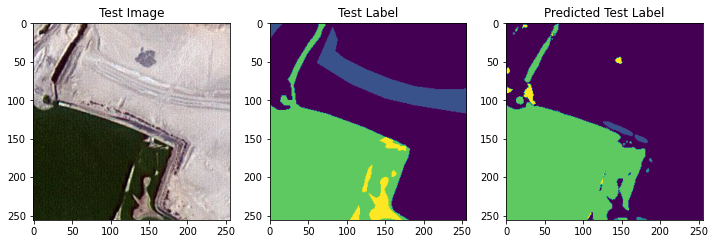

In [3]:
import random
num = random.randint(0, len(X_test))
test_img = X_test[num]
ground_truth=y_test_argmax[num]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Test Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Predicted Test Label')
plt.imshow(predicted_img)
plt.show()

## Prediction of Larger Tile by using patchify

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm
from smooth_blending import predict_img_with_smooth_windowing
from Metrics import Jacard_coefficient 
import random
import glob

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

img_path=glob.glob('./Semantic segmentation dataset/Tile1/images/*')
mask_path=glob.glob('./Semantic segmentation dataset/Tile1/masks/*')

num=random.randint(0,len(img_path)-1)
img = cv2.imread(img_path[num])
mask = cv2.cvtColor(cv2.imread(mask_path[num]),cv2.COLOR_BGR2RGB)

Segmentation Models: using `keras` framework.


In [ ]:
from keras.models import load_model
model = load_model("./satalite.hdf5", compile=False)

patch_size = 256
n_classes = 6

# Predict on patch 
SIZE_X = (img.shape[1]//patch_size)*patch_size #Nearest size divisible by 256
SIZE_Y = (img.shape[0]//patch_size)*patch_size #Nearest size divisible by 256
large_img = Image.fromarray(img)
large_img = large_img.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
large_img = np.array(large_img)  

patch_img = patchify(large_img, (patch_size, patch_size, 3), step=patch_size)  #no overlap
patch_img = patch_img[:,:,0,:,:,:]

# for plotting
from preprocessing import rgb_label
label = Image.fromarray(mask)
label = label.crop((0 ,0, SIZE_X, SIZE_Y))
label = np.array(label)  
label = rgb_label(label)

img shape: (512, 768, 3)
label shape: (512, 768)
unpatched_prediction shape: (512, 768)


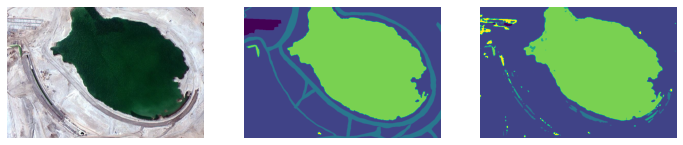

In [3]:
prediction = []
for i in range(patch_img.shape[0]):
    for j in range(patch_img.shape[1]):
        
        single_patch_img = patch_img[i,j,:,:,:]
        
        # Using minmaxscaler for normalization
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        pred = model.predict(single_patch_img)
        pred = np.argmax(pred, axis=3)
        pred = pred[0, :,:]
                                 
        prediction.append(pred)
        
patched_prediction = np.array(prediction)
patched_prediction = np.reshape(patched_prediction, [patch_img.shape[0], patch_img.shape[1], 
                                            patch_img.shape[2], patch_img.shape[3]])

unpatched_prediction = unpatchify(patched_prediction, (large_img.shape[0], large_img.shape[1]))


plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(large_img)
plt.axis('off')
print('img shape:',large_img.shape)
plt.subplot(132)
plt.imshow(label)
print('label shape:',label.shape)
plt.axis('off')
plt.subplot(133)
plt.imshow(unpatched_prediction)
print('unpatched_prediction shape:',unpatched_prediction.shape)
plt.axis('off')
plt.show()

## Smooth Blending Algorithm
https://github.com/Vooban/Smoothly-Blend-Image-Patches

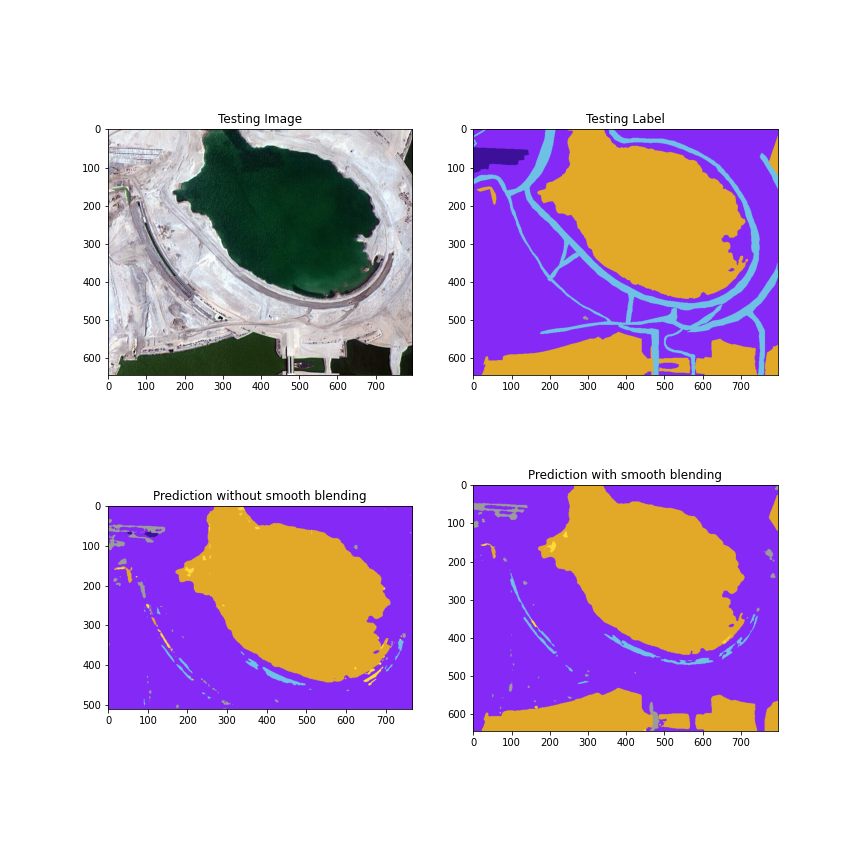